<pre>
<center><b><h1>Machine Learning </b></center>

<center><b><h1>23010101074</b></center>    
<pre>    

## Import Dependencies

In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import sklearn

Load and Inspect(Read the File)

In [2]:
# nRowsRead = 1000 # specify 'None' if want to read whole file
df = pd.read_csv('cardio_train.csv', delimiter=';')
df.dataframeName = 'cardio_train.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} column')

There are 70000 rows and 13 column


In [3]:
df.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Get General Info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [6]:
n = df.isnull().sum()
n

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

### Inspect basic info & duplicates

In [8]:
df.shape
df.info()
df.describe(include='all').T
# duplicates
print("duplicates:", df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB
duplicates: 0


### Convert age → years, drop id

In [10]:
# age is in days; create age_years
df['age_years'] = (df['age'] / 365).astype(int)
df.drop(columns=['id', 'age'], inplace=True)


### Detect missing values & hidden missing patterns

In [12]:
df.isnull().sum()   # Kaggle file typically has no nulls, but check
# Hidden missing: check for sentinel values like 0 in fields that shouldn't be 0
for col in ['height', 'weight', 'ap_hi', 'ap_lo']:
    print(col, "zeros:", (df[col]==0).sum())


height zeros: 0
weight zeros: 0
ap_hi zeros: 0
ap_lo zeros: 21


#### Fix inconsistent entries

##### ap_hi (systolic) must be > ap_lo (diastolic). Remove or correct rows where ap_lo > ap_hi.
##### Remove physiologically implausible values:
##### Height: 120 cm – 220 cm (adjustable)
##### Weight: 30 kg – 250 kg
##### Systolic (ap_hi): 70 – 270 (but we'll be conservative: 80–300). Later we tighten.
##### Diastolic (ap_lo): 40 – 200

In [15]:
# remove rows where ap_lo > ap_hi
mask = df['ap_lo'] <= df['ap_hi']
df = df[mask].copy()

# apply reasonable ranges
mask = (
    (df['height'].between(120, 220)) &
    (df['weight'].between(30, 250)) &
    (df['ap_hi'].between(80, 300)) &
    (df['ap_lo'].between(40, 200))
)
df = df[mask].copy()


### Engineer BMI

In [17]:
df['height_m'] = df['height'] / 100
df['BMI'] = df['weight'] / (df['height_m'] ** 2)
# optional BMI category
def bmi_cat(b):
    if b < 18.5: return 'under'
    if b < 25: return 'normal'
    if b < 30: return 'over'
    return 'obese'
df['BMI_cat'] = df['BMI'].apply(bmi_cat)


### Visual representation of BMI

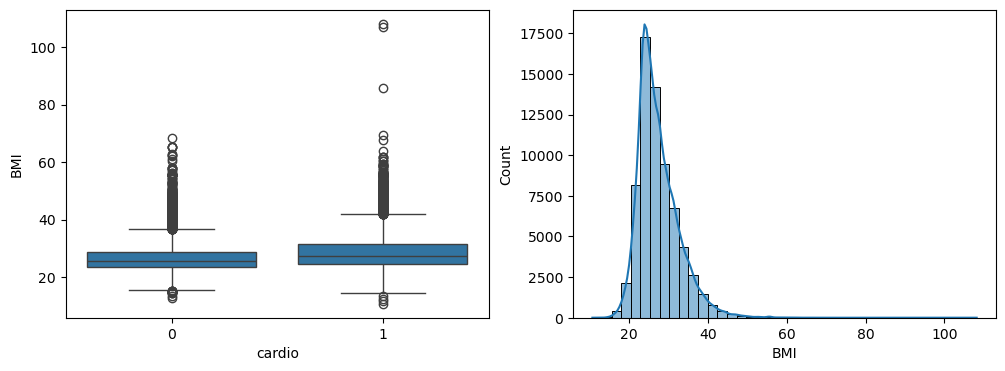

In [19]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); sns.boxplot(x='cardio', y='BMI', data=df)
plt.subplot(1,2,2); sns.histplot(df['BMI'], bins=40, kde=True);
plt.show()


### Isolation Forest for Outlier Detection

In [21]:
num_features = ['age_years','height','weight','ap_hi','ap_lo','BMI']

In [22]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.02,   # 2% expected outliers
    random_state=42
)
df['outlier_flag'] = iso_forest.fit_predict(df[num_features])

In [24]:
print(df['outlier_flag'].value_counts())

outliers = df[df['outlier_flag'] == -1]
outliers.describe()


outlier_flag
 1    67240
-1     1373
Name: count, dtype: int64


,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,height_m,BMI,outlier_flag
count,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,1373.0
mean,1.316824,162.859432,100.075288,147.181355,91.391114,1.571741,1.378004,0.101966,0.081573,0.782957,0.660597,52.141296,1.628594,37.680535,-1.0
std,0.465408,12.463646,32.757189,34.373271,20.826350,0.776938,0.675916,0.302715,0.273813,0.412382,0.473679,7.885967,0.124636,12.037073,0.0
min,1.000000,120.000000,30.000000,80.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.000000,1.200000,13.493001,-1.0
25%,1.000000,155.000000,79.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,45.000000,1.550000,29.060607,-1.0
50%,1.000000,162.000000,107.000000,150.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,53.000000,1.620000,39.708161,-1.0
75%,2.000000,172.000000,123.000000,170.000000,100.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,59.000000,1.720000,46.241247,-1.0
max,2.000000,198.000000,200.000000,240.000000,182.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.000000,1.980000,108.169847,-1.0


In [25]:
df = df[df['outlier_flag'] == 1].copy()
df.drop(columns='outlier_flag', inplace=True)
print("Shape after Isolation Forest:", df.shape)

Shape after Isolation Forest: (67240, 15)


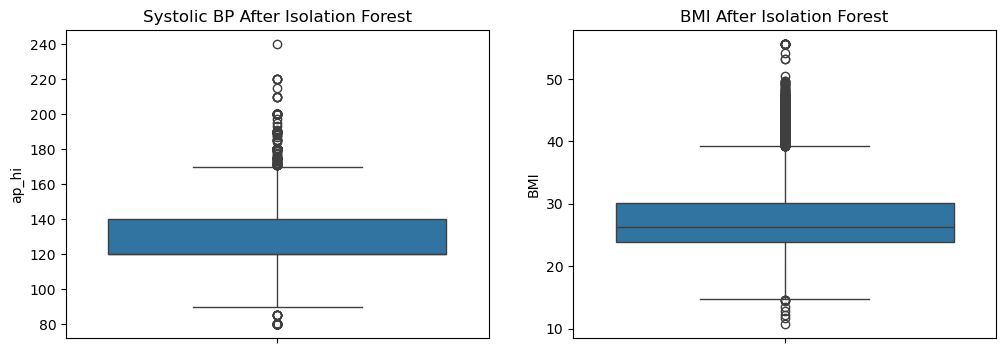

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.boxplot(y=df['ap_hi'], ax=axes[0])
axes[0].set_title("Systolic BP After Isolation Forest")
sns.boxplot(y=df['BMI'], ax=axes[1])
axes[1].set_title("BMI After Isolation Forest")
plt.show()

In [31]:
df['is_outlier'] = (iso_forest.fit_predict(df[num_features]) == -1).astype(int)

In [34]:
# Pulse Pressure = Systolic - Diastolic
# A wide pulse pressure is a strong indicator of cardiovascular risk.
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']

### Train test Split

In [39]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop('cardio', axis=1)   # Features
y = df['cardio']                # Target
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=23,stratify=y)
# Check shapes
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training target distribution:\n", y_train.value_counts(normalize=True))
print("Testing target distribution:\n", y_test.value_counts(normalize=True))


Training set shape: (53792, 16)
Testing set shape: (13448, 16)
Training target distribution:
 cardio
0    0.508644
1    0.491356
Name: proportion, dtype: float64
Testing target distribution:
 cardio
0    0.508626
1    0.491374
Name: proportion, dtype: float64


###  Scaling Numerical Data (StandardScaler)

In [41]:
import pickle
from sklearn.preprocessing import StandardScaler
num_cols = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo', 'BMI', 'pulse_pressure']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])  # fit ONCE

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✅ Correct Scaler object saved as 'scaler.pkl'")
print("Scaled Data Sample:")
print(X_train_scaled[:3])


✅ Correct Scaler object saved as 'scaler.pkl'
Scaled Data Sample:
[[ 0.46664922  1.48274004  0.56572937  0.87050023 -0.12164247 -0.22672464
   1.31450666]
 [-0.86814515  0.32799272 -0.19464454 -1.02320689 -1.23723419 -0.37033397
  -0.45220837]
 [ 1.50482262 -0.31353357  0.48969198  3.39544306  2.10954098  0.67370349
   3.0812217 ]]


In [42]:
cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
X_train_cat = pd.get_dummies(
    X_train[cat_cols],
    drop_first=True
)
X_train_final = pd.concat([pd.DataFrame(X_train_scaled, columns=num_cols, index=X_train.index)],axis=1)
X_test_final = pd.concat(
    [pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)],
    axis=1
)
print("Final training shape:", X_train_final.shape)
print("Final testing shape :", X_test_final.shape)

Final training shape: (53792, 7)
Final testing shape : (13448, 7)


In [43]:
# One-hot encode
X_train_cat = pd.get_dummies(X_train[cat_cols], drop_first=True)
X_test_cat = pd.get_dummies(X_test[cat_cols], drop_first=True)

# Align train & test columns
X_train_cat, X_test_cat = X_train_cat.align(
    X_test_cat,
    join='left',
    axis=1,
    fill_value=0
)

# Combine with scaled numerical features
X_train_final = pd.concat(
    [
        pd.DataFrame(X_train_scaled, columns=num_cols, index=X_train.index),
        X_train_cat
    ],
    axis=1
)

X_test_final = pd.concat(
    [
        pd.DataFrame(
            scaler.transform(X_test[num_cols]),
            columns=num_cols,
            index=X_test.index
        ),
        X_test_cat
    ],
    axis=1
)

print("Final Training Shape:", X_train_final.shape)
print("Final Testing Shape :", X_test_final.shape)

X_train_final.head()


Final Training Shape: (53792, 13)
Final Testing Shape : (13448, 13)


,age_years,height,weight,ap_hi,ap_lo,BMI,pulse_pressure,gender,cholesterol,gluc,smoke,alco,active
55435,0.466649,1.482740,0.565729,0.870500,-0.121642,-0.226725,1.314507,2,1,1,0,0,0
20106,-0.868145,0.327993,-0.194645,-1.023207,-1.237234,-0.370334,-0.452208,1,1,1,0,0,1
61802,1.504823,-0.313534,0.489692,3.395443,2.109541,0.673703,3.081222,1,2,2,0,0,1
5556,0.318339,-2.109807,1.782328,0.239265,0.993949,3.541064,-0.452208,1,3,1,0,0,1
2291,1.059891,0.712908,-0.498794,0.239265,-0.121642,-0.842931,0.431149,1,2,1,0,0,0



### Linear, Logistic & Polynomial Regression


In [45]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline

# ------------------------- 
# 1️⃣ LINEAR REGRESSION
# -------------------------
lin_reg = LinearRegression()
lin_reg.fit(X_train_final, y_train)

y_pred_lin = lin_reg.predict(X_test_final)

print("LINEAR REGRESSION")
print("MSE:", mean_squared_error(y_test, y_pred_lin))
print("-" * 40)


# -------------------------
# 2️⃣ LOGISTIC REGRESSION
# -------------------------
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_final, y_train)

y_pred_log = log_reg.predict(X_test_final)

print("LOGISTIC REGRESSION")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("-" * 40)


# -------------------------
# 3️⃣ POLYNOMIAL REGRESSION
# -------------------------
poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('lin_reg', LinearRegression())
])

poly_model.fit(X_train_final, y_train)

y_pred_poly = poly_model.predict(X_test_final)

print("POLYNOMIAL REGRESSION (Degree = 2)")
print("MSE:", mean_squared_error(y_test, y_pred_poly))


LINEAR REGRESSION
MSE: 0.1931430731854534
----------------------------------------
LOGISTIC REGRESSION
Accuracy: 0.7278405710886378
----------------------------------------
POLYNOMIAL REGRESSION (Degree = 2)
MSE: 0.1883913447339435


### Random Forest

In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']


num_cols = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo', 'BMI', 'pulse_pressure']
cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

# Split Data
X = df.drop('cardio', axis=1)
y = df['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)

# Scale Numerical Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

# One-Hot Encode Categorical Data
X_train_cat = pd.get_dummies(X_train[cat_cols], drop_first=True)
X_test_cat = pd.get_dummies(X_test[cat_cols], drop_first=True)

# Align columns (just in case)
X_train_cat, X_test_cat = X_train_cat.align(X_test_cat, join='left', axis=1, fill_value=0)

# Combine Final Dataframes
X_train_final = pd.concat([pd.DataFrame(X_train_scaled, columns=num_cols, index=X_train.index), X_train_cat], axis=1)
X_test_final = pd.concat([pd.DataFrame(X_test_scaled, columns=num_cols, index=X_test.index), X_test_cat], axis=1)

# ==========================================
# 3. RANDOM FOREST WITH HYPERPARAMETER TUNING
# ==========================================
print("Training Optimized Random Forest... (This may take 1-2 minutes)")

# Define a grid of parameters to test
# We limit max_depth to prevent the model from memorizing noise (overfitting)
param_dist = {
    'n_estimators': [100, 200, 300],        # Number of trees
    'max_depth': [10, 15, 20],              # Maximum depth of tree (prevents overfitting)
    'min_samples_split': [5, 10],           # Minimum samples required to split a node
    'min_samples_leaf': [2, 4],             # Minimum samples required at a leaf node
    'max_features': ['sqrt']                # Number of features to consider at every split
}

# Initialize Base Model
rf = RandomForestClassifier(random_state=42)

# Use RandomizedSearchCV to find the best parameters automatically
# n_iter=10 means it will try 10 random combinations from the grid above
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                               n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
rf_random.fit(X_train_final, y_train)

# Get the best model from the search
best_rf_model = rf_random.best_estimator_

print(f"Best Parameters Found: {rf_random.best_params_}")

# ==========================================
# 4. EVALUATION
# ==========================================
y_pred = best_rf_model.predict(X_test_final)

print("\n" + "="*40)
print(f"FINAL ACCURACY: {accuracy_score(y_test, y_pred):.4f}")
print("="*40)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Training Optimized Random Forest... (This may take 1-2 minutes)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters Found: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 15}

FINAL ACCURACY: 0.7343

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6840
           1       0.75      0.69      0.72      6608

    accuracy                           0.73     13448
   macro avg       0.74      0.73      0.73     13448
weighted avg       0.74      0.73      0.73     13448


Confusion Matrix:
[[5339 1501]
 [2072 4536]]


In [50]:
import joblib #Instead of pickle 
joblib.dump(best_rf_model, 'cardio_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# 1. Check for Overfitting
print(f"Training Accuracy: {best_rf_model.score(X_train_final, y_train):.4f}")
print(f"Testing Accuracy:  {best_rf_model.score(X_test_final, y_test):.4f}")

# 2. Cross Validation (The Stress Test)
# This trains the model 5 separate times on different data chunks
cv_scores = cross_val_score(best_rf_model, X_train_final, y_train, cv=5, scoring='accuracy')
print(f"Cross-Val Average: {cv_scores.mean():.4f} (Standard Deviation: {cv_scores.std():.4f})")

# 3. ROC-AUC (The Medical Standard)
# Probabilities instead of hard predictions (0 or 1)
y_probs = best_rf_model.predict_proba(X_test_final)[:, 1]
print(f"ROC-AUC Score:     {roc_auc_score(y_test, y_probs):.4f}")

Training Accuracy: 0.7793
Testing Accuracy:  0.7343
Cross-Val Average: 0.7303 (Standard Deviation: 0.0026)
ROC-AUC Score:     0.7998
